# Phase 3: Asking meaningful questions

In [1]:
import pandas as pd
import geopandas
import seaborn as sns
import numpy as np  
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Question 1:

### Question:
- Câu hỏi: Sự phân bố của các căn hộ air bnb như thế nào?.
- Trả lời được câu hỏi này sẽ giúp ta thấy được sự tình hình nhà ở theo từng khu vực. Từ đó, có thể thấy được đâu là trung tâm, hay đâu là khu vực tiềm năng để có thể đầu tư.
- Cách trả lời: dựa vào longtitude và latitude.

In [2]:
raw_df = pd.read_csv('./Data/processed_data/processed_data.csv')

In [3]:
aggregation_functions = {
    'price': 'mean',
    'id':'count'
}

result = raw_df.groupby(['neighbourhood_group']).agg(aggregation_functions).reset_index()
result

,neighbourhood_group,price,id
0,Bronx,87.496792,1091
1,Brooklyn,124.383207,20104
2,Manhattan,196.875814,21661
3,Queens,99.517649,5666
4,Staten Island,114.812332,373


In [4]:
city_df = geopandas.read_file(geopandas.datasets.get_path('nybb'))

result.rename(columns={'neighbourhood_group':'BoroName'}, inplace=True)
city_df = city_df.merge(right=result,how='inner',on='BoroName')
city_df

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27340\1661923646.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  city_df = geopandas.read_file(geopandas.datasets.get_path('nybb'))


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,price,id
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227....",114.812332,373
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957...",99.517649,5666
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100...",124.383207,20104
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940....",196.875814,21661
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",87.496792,1091


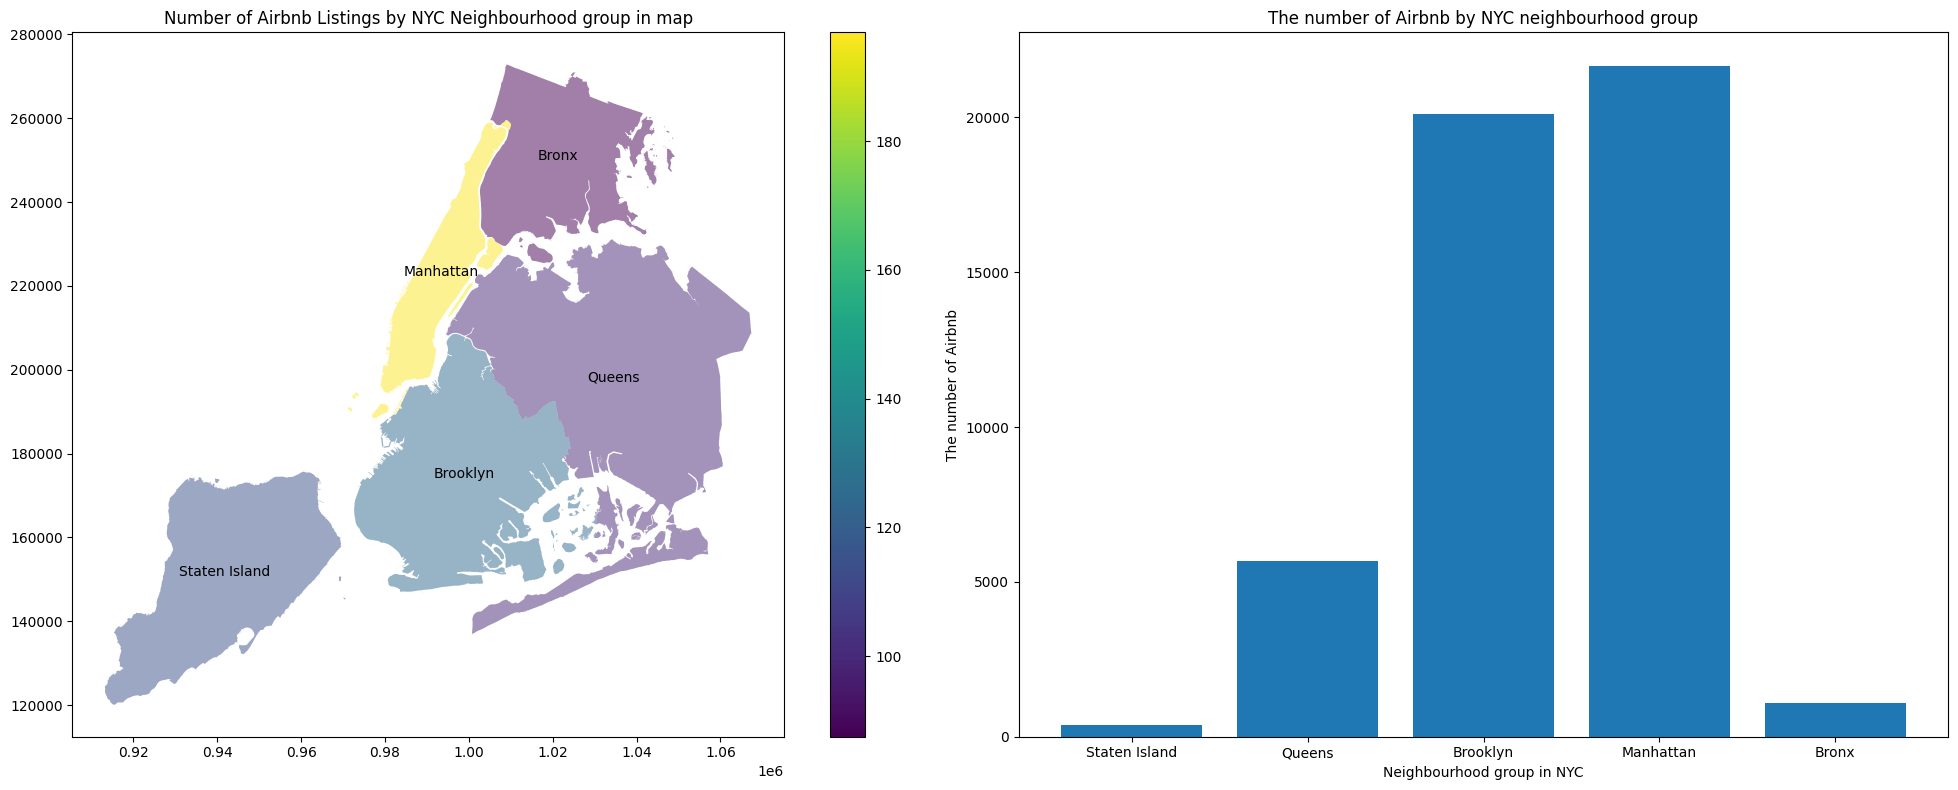

In [5]:
fig,ax = plt.subplots(1,2, figsize=(20,8))
city_df.plot(column='price' ,alpha=.5, ax=ax[0], legend=True)
city_df.apply(lambda x: ax[0].annotate(text=x.BoroName, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
ax[0].set_title("Number of Airbnb Listings by NYC Neighbourhood group in map")



ax[1].bar(city_df['BoroName'],city_df['id'])
ax[1].set_xlabel('Neighbourhood group in NYC')
ax[1].set_ylabel('The number of Airbnb')
ax[1].set_title('The number of Airbnb by NYC neighbourhood group')
plt.tight_layout()
plt.show()

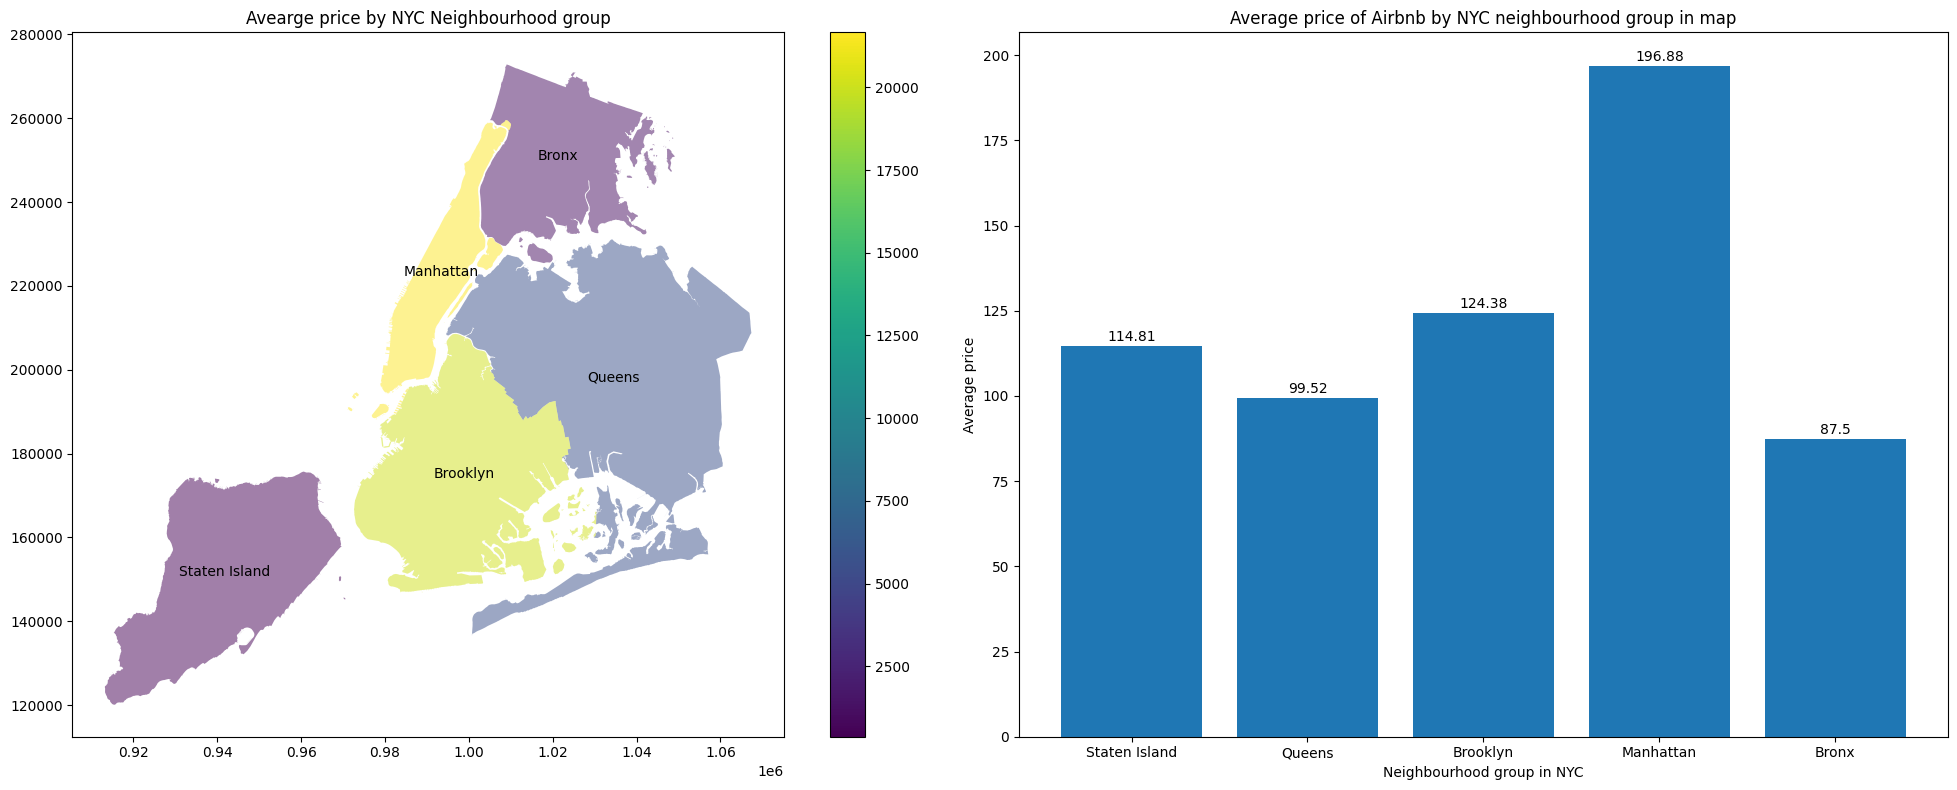

In [6]:
fig,ax = plt.subplots(1,2, figsize=(20,8))
city_df.plot(column='id' ,alpha=.5, ax=ax[0], legend=True)
city_df.apply(lambda x: ax[0].annotate(text=x.BoroName, color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
ax[0].set_title("Avearge price by NYC Neighbourhood group")

ax[1].bar(city_df['BoroName'],city_df['price'])
ax[1].set_xlabel('Neighbourhood group in NYC')
ax[1].set_ylabel('Average price')
ax[1].set_title('Average price of Airbnb by NYC neighbourhood group in map')
for index, value in enumerate(city_df['price']):
    ax[1].text(index, value + 0.5, str(round(value,2)), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Question 2:

- Câu hỏi: Tình hình thị trường các căn hộ có giá trên 1000$ 1 đêm với số đêm tối thiểu ít hơn 2 ngày diễn ra như thế nào?
- Trả lời câu hỏi này sẽ giúp khách hàng so sánh mức giá, sô lượng đánh giá, cũng như giúp đưa ra quyết định thuê một khu vực nào đó. Hơn nữa, có thể giúp nhà đầu tư nhìn được tổng quan thị trường các căn hộ (có giá trên 1000$ 1 đêm và thời hạn thuê tối thiểu ít hơn 2 ngày).

### Preprocessing

In [2]:
df = pd.read_csv('./Data/processed_data/processed_data.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
column_list = ['id',
              'name', 
              'host_id', 
              'neighbourhood_group', 
              'room_type', 
              'price', 
              'minimum_nights', 
              'number_of_reviews']
new_df = df[column_list]
new_df.head()

,id,name,host_id,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Private room,149,1,9
1,2595,Skylit Midtown Castle,2845,Manhattan,Entire home/apt,225,1,45
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Private room,150,3,0
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Entire home/apt,89,1,270
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,Entire home/apt,80,10,9


In [4]:
df_satisfied =  new_df[(new_df['price'] >= 1000) & (new_df['minimum_nights'] <= 2)]
df_satisfied.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1105 to 48535
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   160 non-null    int64 
 1   name                 160 non-null    object
 2   host_id              160 non-null    int64 
 3   neighbourhood_group  160 non-null    object
 4   room_type            160 non-null    object
 5   price                160 non-null    int64 
 6   minimum_nights       160 non-null    int64 
 7   number_of_reviews    160 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 11.2+ KB


### Analyzing to get the answer

In [5]:
group_counts  = df_satisfied.groupby('neighbourhood_group').count()['id']
group_counts

neighbourhood_group
Bronx              2
Brooklyn          41
Manhattan        110
Queens             5
Staten Island      2
Name: id, dtype: int64

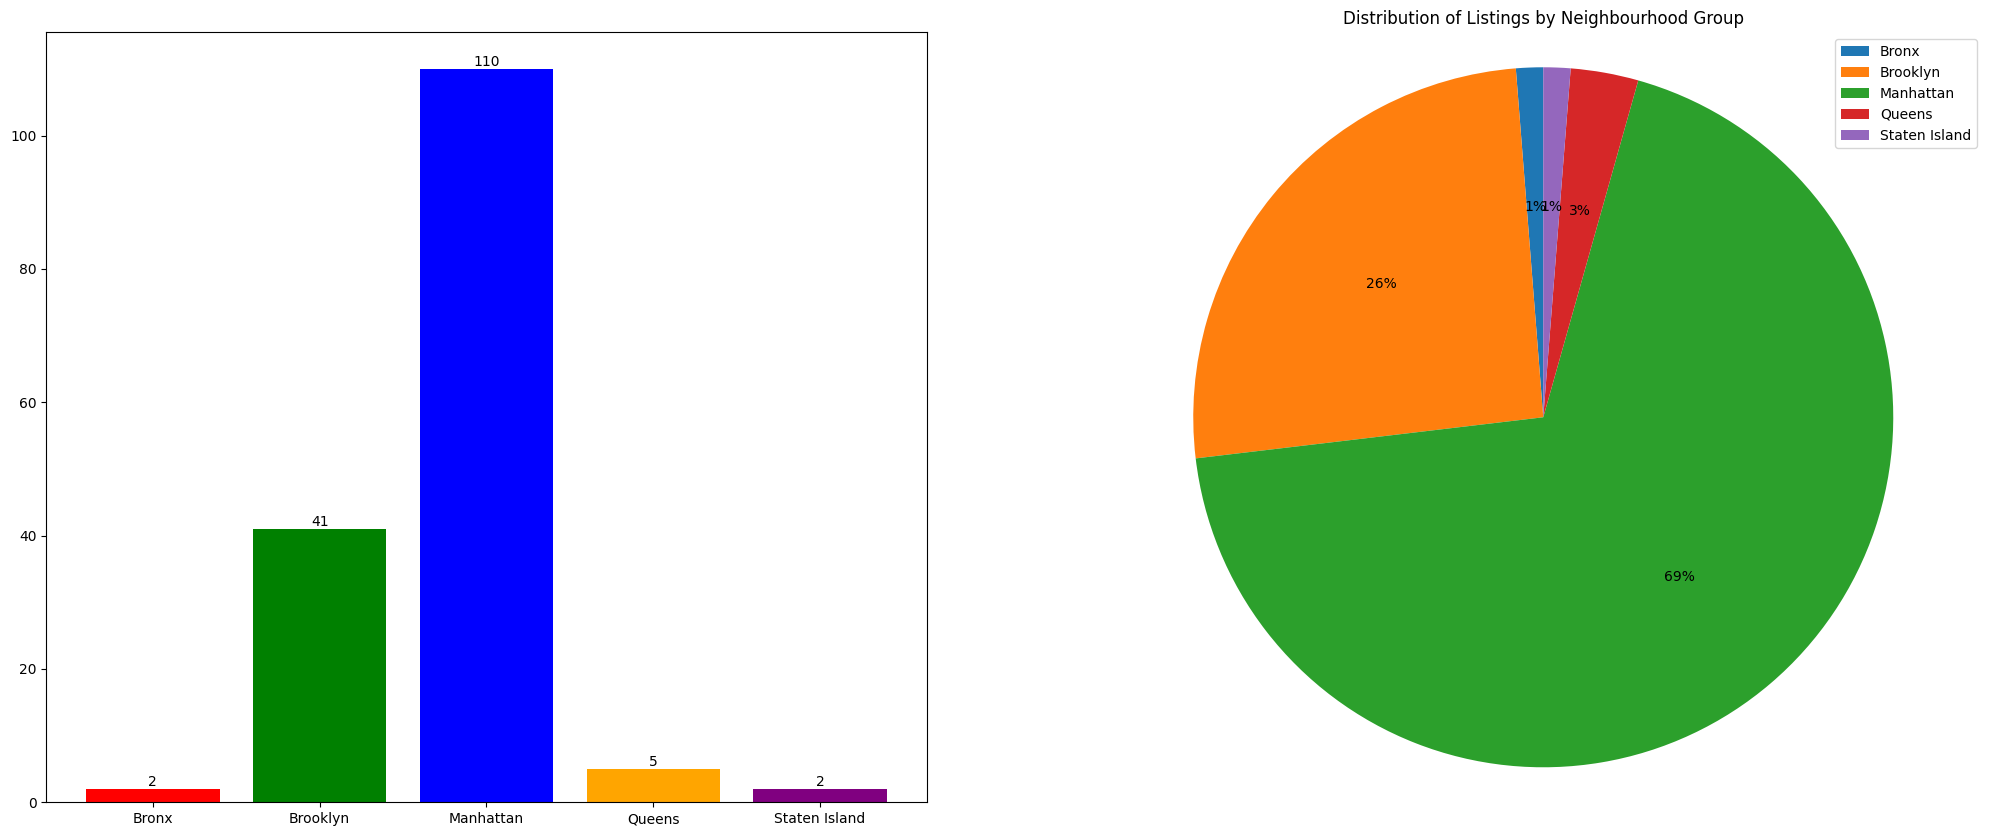

In [6]:
fig, axes = plt.subplots(1,2,figsize=(25,10))

axes[0].bar(group_counts.index, group_counts.values, color=['red', 'green', 'blue', 'orange', 'purple'])
axes[0].bar_label(axes[0].containers[0])

axes[1].pie(group_counts.values, labels=None, autopct='%1.f%%', startangle=90)
axes[1].legend(labels=group_counts.index, loc='upper right')
axes[1].set_title('Distribution of Listings by Neighbourhood Group')
axes[1].axis('equal') 

plt.show()

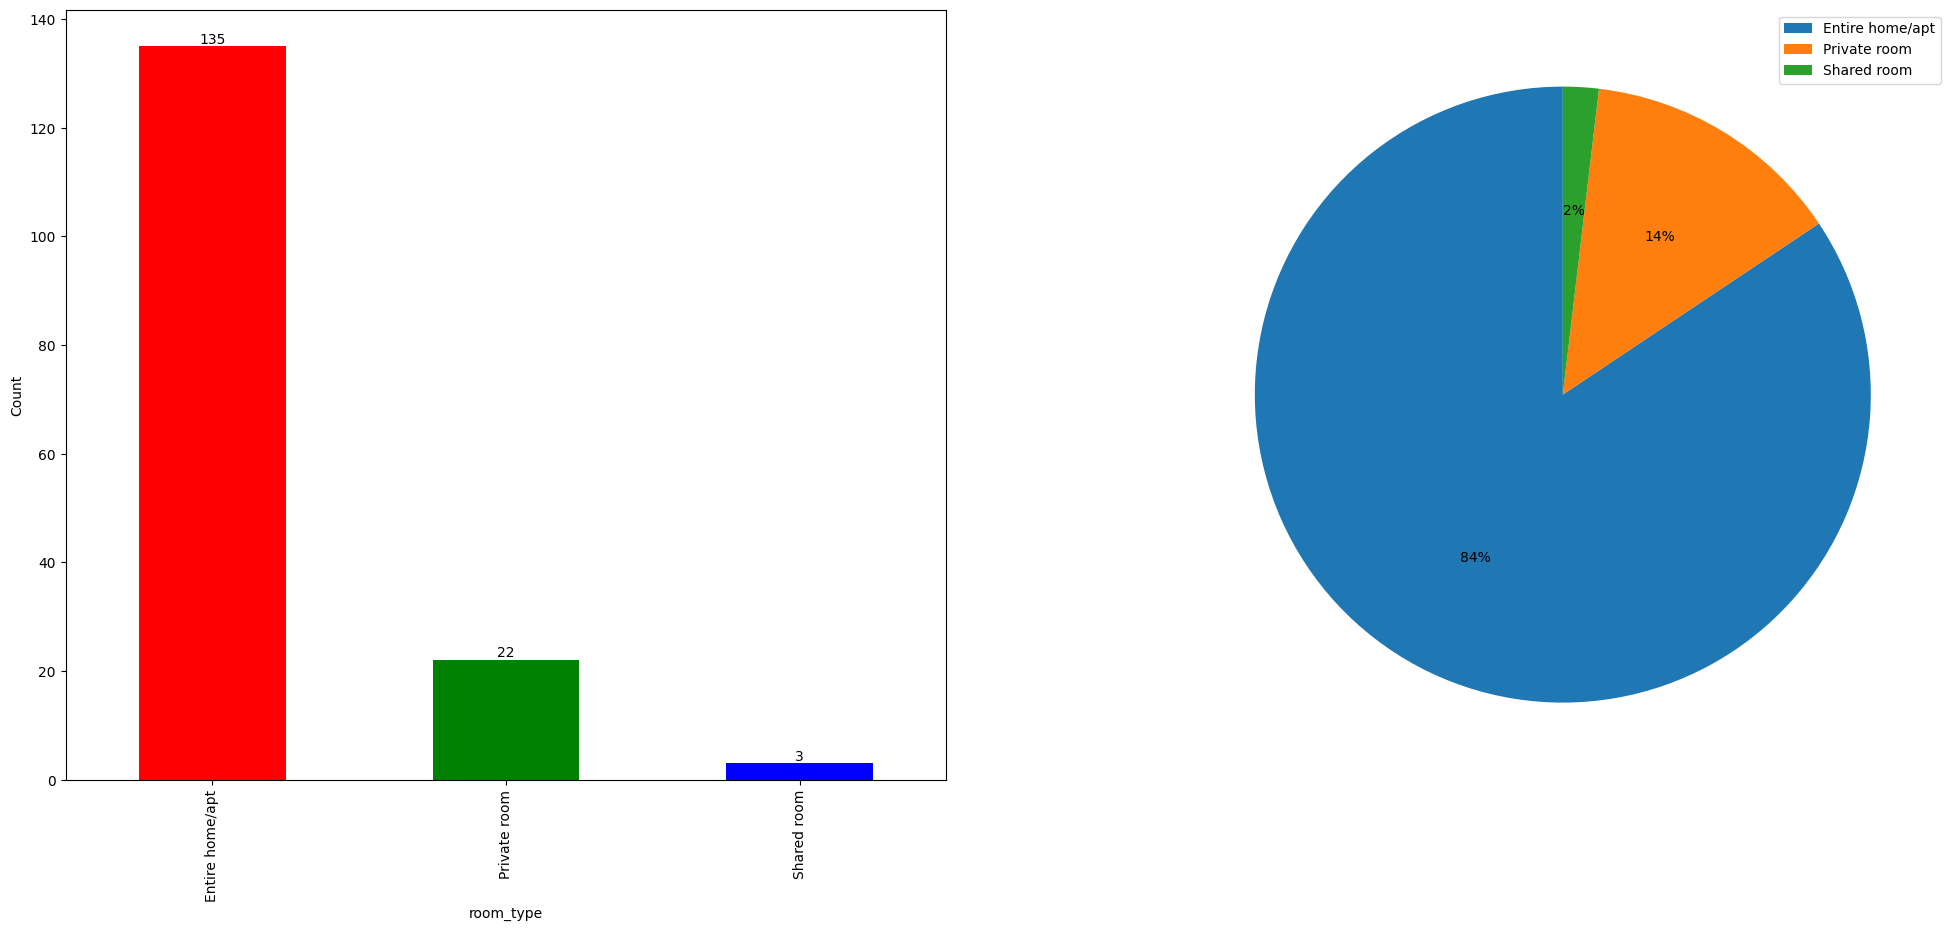

In [7]:
fig, axes = plt.subplots(1,2,figsize=(25,10))

df_satisfied['room_type'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green', 'blue'])
axes[0].bar_label(axes[0].containers[0])
axes[0].set_ylabel('Count')

df_satisfied['room_type'].value_counts().plot(kind='pie', ax=axes[1], legend=True, labels=None, autopct='%1.f%%', startangle=90)
axes[1].set_ylabel(None)
plt.show()

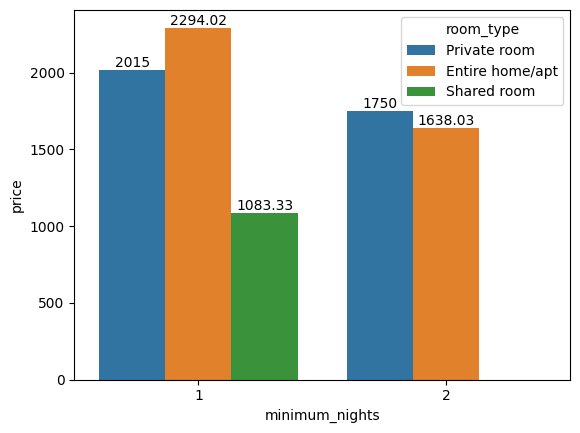

In [8]:
ax = sns.barplot(data=df_satisfied, x = 'minimum_nights', y = 'price', hue='room_type', errorbar=None)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.show()

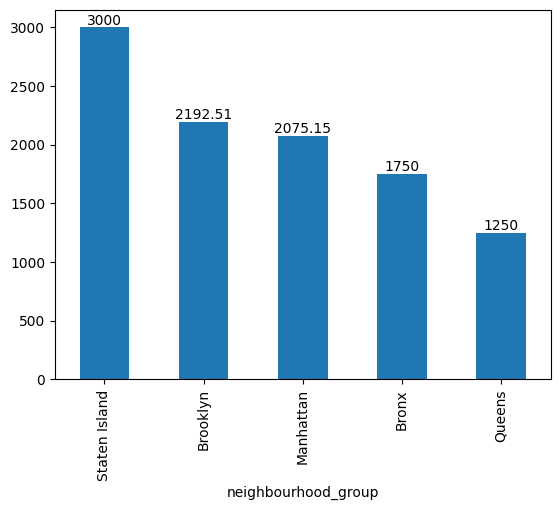

In [9]:
ax = df_satisfied[['neighbourhood_group', 'price']].groupby('neighbourhood_group').mean().sort_values(by='price', ascending=False).plot(kind='bar', legend=None)
ax.bar_label(ax.containers[0])
plt.show()

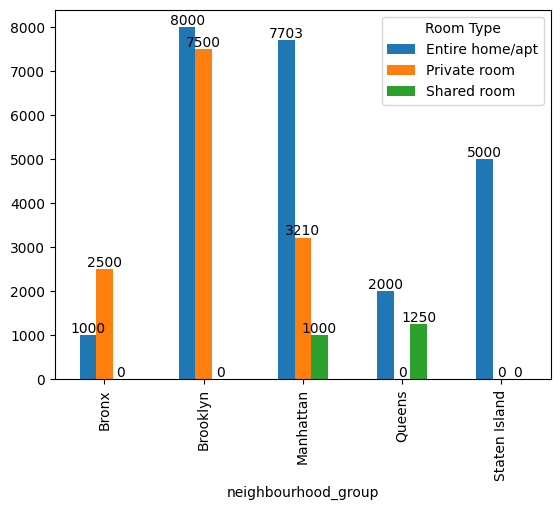

In [10]:
ax = df_satisfied[['neighbourhood_group', 'room_type', 'price']].groupby(['neighbourhood_group', 'room_type']).max().unstack(1).plot(kind='bar', legend=None)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.legend(title='Room Type', labels=['Entire home/apt', 'Private room', 'Shared room'], loc='upper right')
plt.show()

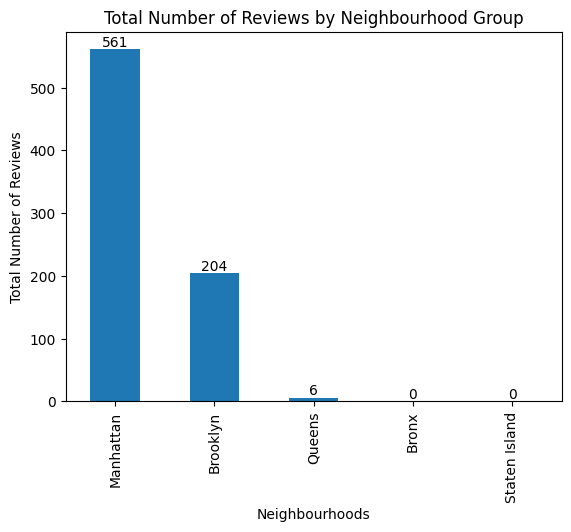

In [11]:
ax = df_satisfied.groupby('neighbourhood_group').sum()['number_of_reviews'].sort_values(ascending=False).plot(kind='bar')
ax.bar_label(ax.containers[0])

plt.xlabel('Neighbourhoods')
plt.ylabel('Total Number of Reviews')
plt.title('Total Number of Reviews by Neighbourhood Group')

plt.show()

## Question 3:

### Question:
- Câu hỏi: Hệ thống dự đoán giá phòng.
- Trả lời được câu hỏi này sẽ giúp người đặt phòng dự đoán được giá của căn hộ mình cần thuê, cũng như giúp chủ các căn hộ đưa ra mức giá phù hợp cho căn hộ của mình.
- Cách trả lời: Xây dựng mô hình Linear Regression.

### Preprocessing

In [12]:
df_satisfied = df[df['price'] <= 1000]
df_satisfied.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [13]:
df_satisfied['price'].describe()

count    48656.000000
mean       141.279842
std        116.737468
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       1000.000000
Name: price, dtype: float64

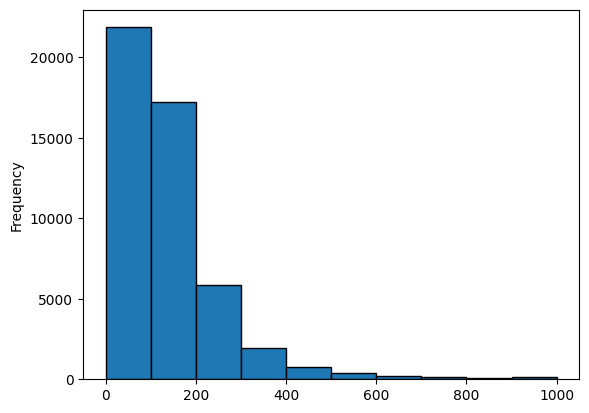

In [14]:
df[df['price'] <= 1000]['price'].plot(kind='hist', edgecolor='black')
plt.show()

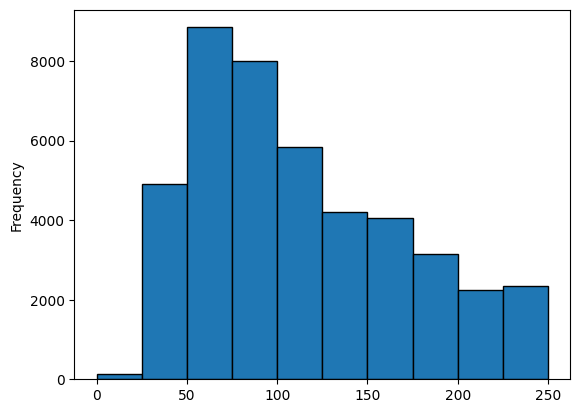

In [15]:
df[df['price'] <= 250]['price'].plot(kind='hist', edgecolor='black')
plt.show()

In [16]:
df_satisfied["minimum_nights"].describe()

count    48656.000000
mean         6.973549
std         20.265616
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [17]:
df_satisfied.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48656 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48656 non-null  int64  
 1   name                            48640 non-null  object 
 2   host_id                         48656 non-null  int64  
 3   host_name                       48635 non-null  object 
 4   neighbourhood_group             48656 non-null  object 
 5   neighbourhood                   48656 non-null  object 
 6   latitude                        48656 non-null  float64
 7   longitude                       48656 non-null  float64
 8   room_type                       48656 non-null  object 
 9   price                           48656 non-null  int64  
 10  minimum_nights                  48656 non-null  int64  
 11  number_of_reviews               48656 non-null  int64  
 12  last_review                     38736

In [18]:
df_satisfied = df_satisfied.drop(columns=['host_id', 'name','id','host_name','last_review', 'neighbourhood'])

In [19]:
categorical_column_list = df_satisfied.select_dtypes(include='object').columns.to_list()
categorical_column_list

['neighbourhood_group', 'room_type']

In [20]:
df_one_hot = pd.get_dummies(df_satisfied, columns= categorical_column_list, prefix=['ng', 'rt'], drop_first=True)
df_one_hot

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ng_Brooklyn,ng_Manhattan,ng_Queens,ng_Staten Island,rt_Private room,rt_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,True,False,False,False,True,False
1,40.75362,-73.98377,225,1,45,0.38,2,355,False,True,False,False,False,False
2,40.80902,-73.94190,150,3,0,0.00,1,365,False,True,False,False,True,False
3,40.68514,-73.95976,89,1,270,4.64,1,194,True,False,False,False,False,False
4,40.79851,-73.94399,80,10,9,0.10,1,0,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,9,True,False,False,False,True,False
48891,40.70184,-73.93317,40,4,0,0.00,2,36,True,False,False,False,True,False
48892,40.81475,-73.94867,115,10,0,0.00,1,27,False,True,False,False,False,False
48893,40.75751,-73.99112,55,1,0,0.00,6,2,False,True,False,False,False,True


In [21]:
# Split data into features (X) and target variable (Y)
X = df_one_hot.drop(['price'], axis=1)
Y = df_one_hot['price']

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [22]:
# Initialize the models
models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('RF', RandomForestRegressor())]

# Initialize lists to store metrics
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []

# Define the hyperparameters for each model
param_grids = {
    'LR': {},
    'KNN': {'n_neighbors': [3, 5]},
    'RF': {'n_estimators': [30, 50], 'max_depth': [None, 10]}
}

# Train and evaluate the models with hyperparameter tuning
for name, regressor in models:
    print(f"Hyperparameter Tuning for {name}:")
    start_time = time.time()

    if param_grids[name]:
        grid_search = GridSearchCV(regressor, param_grid=param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_model = grid_search.best_estimator_

        print(f"Best parameters: {grid_search.best_params_}")
    else:
        best_model = regressor.fit(x_train, y_train)

    y_pred = best_model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    execution_time = time.time() - start_time

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    execution_times.append(execution_time)

Hyperparameter Tuning for LR:
Hyperparameter Tuning for KNN:


Best parameters: {'n_neighbors': 5}
Hyperparameter Tuning for RF:
Best parameters: {'max_depth': 10, 'n_estimators': 50}


In [23]:
result = pd.DataFrame({'RMSE':rmse_scores,
                        'R2 score': r2_scores,
                        'MAE': mae_scores,
                        'MSE': mse_scores,
                        'Execution Time': execution_times}, index=['Linear Regression', 'KNN', 'Random Forest'])
result

,RMSE,R2 score,MAE,MSE,Execution Time
Linear Regression,97.747093,0.327242,57.892782,9554.494142,0.016039
KNN,113.204249,0.097647,71.523325,12815.201985,2.790344
Random Forest,88.604888,0.447202,50.354795,7850.826151,34.214831
